Задание 10. A/B тестирование.


Шаг 1. Изучите материалы лекционных и практических занятий по темам раздела 6.

Шаг 2. Выполните A/B тестирование по предложенному датасету (алгоритм выполнения представлен в практическом занятии по теме 6.1).

Шаг 3. Опубликуйте файл расширения ipynb на платформе Odin.


Кейс: a/b-тест для мобильного приложения.

Имеется мобильное приложение для магазина по продаже продуктов питания. Выдвинута гипотеза о том, что смена шрифтов улучшит качество обслуживания по количеству клиентов, совершающих каждое событие. Для проверки этой гипотезы принято решение провести A/B-тест.   

Договорились принять решение по результатам A/B-теста.
Пользователей разбили на 2 группы: 247 -- контрольная группа со старыми шрифтами (это другая группа, по сравнению с разобранной); 248 -- экспериментальная с новыми шрифтами.

Описание данных

|Признак|Комментарий|
|--:|:--|
|`EventName`|название события|
|`DeviceIDHash`|уникальный идентификатор пользователя|
|`EventTimestamp`|время события|
|`ExpId`|номер группы|

Инструкция по выполнению проекта

Шаг 1. Загрузите данные
- Знакомство с данными;
- Корректность a/b-теста.

Шаг 2. Подготовьте данные
- Корректировка заголовков;
- Типы данных;
- Аномалии пропуски.

Шаг 3. EDA
- Cколько всего событий?
- Сколько всего пользователей в логе?
- Сколько в среднем событий приходится на пользователя?
- Период теста: максимальная и минимальная даты; гистограмма по дате и количеству событий.

Шаг 4. Анализ воронки событий
- Распределение событий: какие события и в каком количестве.
- Сколько пользователей совершали каждое из этих событий?
- Постройте воронку событий: какая доля пользователей проходит на следующий шаг воронки. На каком шаге теряете больше всего пользователей?
Какая доля пользователей доходит от первого события до оплаты?

Шаг 5. Анализ результатов эксперимента
- Сколько пользователей в каждой группе?
- Посчитайте долю пользователей, совершивших каждое из событий.
- Проверьте гипотезу о наличие значимых отличий по результатам теста.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [3]:
#Шаг 1. Загрузите данные
#Шаг 2. Подготовьте данные
df = pd.read_csv('/content/17.11.23+ab_test_home.csv')
df.head(2)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
1,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163822 entries, 0 to 163821
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       163822 non-null  object
 1   DeviceIDHash    163822 non-null  int64 
 2   EventTimestamp  163822 non-null  object
 3   ExpId           163822 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 5.0+ MB


In [15]:
# корректировка заголовков
df.columns = ['event_name', 'user_id', 'event_date', 'group_id']

In [16]:
#корректировка типа данных
df = df.astype({'event_date':'datetime64'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163532 entries, 0 to 163821
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  163532 non-null  object        
 1   user_id     163532 non-null  int64         
 2   event_date  163532 non-null  datetime64[ns]
 3   group_id    163532 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


<ipython-input-16-55d8991c6f1e>:2: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  df = df.astype({'event_date':'datetime64'})


In [17]:
# - поиск дублей;
df.duplicated().sum() #290 дублей
df[df.duplicated()].head(50)
df.drop_duplicates(keep='first', inplace=True)

In [18]:
# Поиск аномальных значений.
# Проверим значения двух признаков
df.event_name.unique()
df.group_id.unique()
df.event_name.value_counts()
df.group_id.value_counts()

248    85582
247    77950
Name: group_id, dtype: int64

In [21]:
# Корректность a/b-теста.
# 1. Количество пользователей в группах примерно одинаковое
print(df.groupby('group_id').user_id.nunique()) #(Нам нужны уникальные пользователи)

# 2. Одни и те же пользователи не состоят в разных группах
set(df[df.group_id == 247].user_id).intersection(set(df[df.group_id == 248].user_id))
#получили пустое множество, значит совпадений в группах нет (set()).

group_id
247    2520
248    2542
Name: user_id, dtype: int64


set()

In [ ]:
# Шаг 3. EDA
#Cколько всего событий?
#Сколько всего пользователей в логе?
#Сколько в среднем событий приходится на пользователя?
#Период теста: максимальная и минимальная даты; гистограмма по дате и количеству событий.

In [22]:
#Cколько всего событий? - столько, сколько строчек в нашей базе.
print(f'''Всего событий в наборе {df.shape[0]} из них уникальных {df.event_name.nunique()}.
События: {'; '.join(df.event_name.unique())}''') #джоин для того, чтобы избавиться от списка

Всего событий в наборе 163532 из них уникальных 5.
События: PaymentScreenSuccessful; CartScreenAppear; MainScreenAppear; Tutorial; OffersScreenAppear


In [23]:
# Сколько всего пользователей в логе?
print(f'''Всего пользователей в наборе {df.user_id.nunique()}''')

Всего пользователей в наборе 5062


In [24]:
# Сколько в среднем событий приходится на пользователя?
print(f'В среднем каждый пользователь совершает {df.shape[0] / df.user_id.nunique():.2f}.')

# Сколько каждый пользователь совершает событий
df.groupby('user_id').event_name.count()\
                     .reset_index()\
                     .sort_values(by='event_name')

В среднем каждый пользователь совершает 32.31.


,user_id,event_name
4796,8740810114826134317,1
1274,2408195006658927235,1
3103,5712952270342213514,1
1302,2463410628813581862,1
3084,5680622852857465310,1
...,...,...
2556,4713748699910253089,824
930,1754140665440434215,1221
3766,6932517045703054087,1439
2496,4623191541214045580,1768


In [45]:
# Период теста: максимальная и минимальная даты;
# гистограмма по дате и количеству событий.
print(df.event_date.agg(['min', 'max']))

# выделим день совершения события

df['event_day'] = df['event_date'].dt.date

df.groupby('event_day').user_id.count().reset_index() #группируем сколько в день было пользователей

min   2019-07-25 11:28:47
max   2019-08-07 21:12:25
Name: event_date, dtype: datetime64[ns]


,event_day,user_id
0,2019-07-25,5
1,2019-07-26,17
2,2019-07-27,31
3,2019-07-28,72
4,2019-07-29,129
5,2019-07-30,283
6,2019-07-31,1410
7,2019-08-01,24580
8,2019-08-02,24608
9,2019-08-03,22707


[Text(0, 0, '2019-07-25'),
 Text(1, 0, '2019-07-26'),
 Text(2, 0, '2019-07-27'),
 Text(3, 0, '2019-07-28'),
 Text(4, 0, '2019-07-29'),
 Text(5, 0, '2019-07-30'),
 Text(6, 0, '2019-07-31'),
 Text(7, 0, '2019-08-01'),
 Text(8, 0, '2019-08-02'),
 Text(9, 0, '2019-08-03'),
 Text(10, 0, '2019-08-04'),
 Text(11, 0, '2019-08-05'),
 Text(12, 0, '2019-08-06'),
 Text(13, 0, '2019-08-07')]

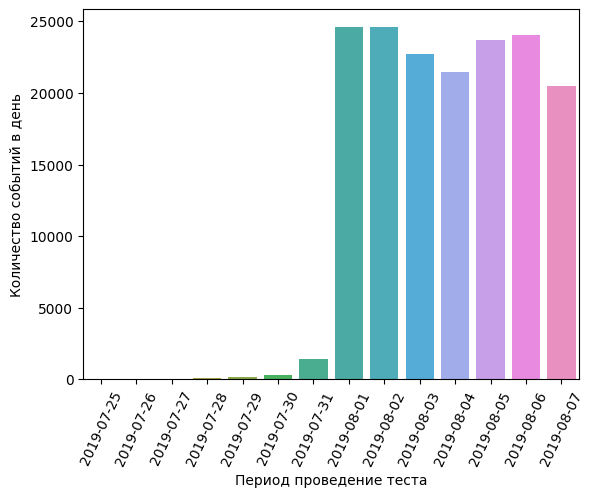

In [26]:
ax = sns.countplot(data=df,
              x=df['event_day'],
              )
ax.set_xlabel('Период проведение теста')
ax.set_ylabel('Количество событий в день')
ax.set_xticklabels(ax.get_xticklabels(), rotation=65)

In [47]:
df['event_date_str'] = df['event_date'].dt.strftime('%Y-%m-%d')
df_ab = df.loc[df['event_date_str'] >= '2019-08-01']
df_ab

,event_name,user_id,event_date,group_id,event_day,event_date_str
1949,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01,2019-08-01
1950,MainScreenAppear,4899590676214355127,2019-08-01 00:10:15,247,2019-08-01,2019-08-01
1951,MainScreenAppear,4899590676214355127,2019-08-01 00:11:28,247,2019-08-01,2019-08-01
1952,OffersScreenAppear,4899590676214355127,2019-08-01 00:11:30,247,2019-08-01,2019-08-01
1953,OffersScreenAppear,4899590676214355127,2019-08-01 00:12:36,247,2019-08-01,2019-08-01
...,...,...,...,...,...,...
163817,MainScreenAppear,2300292234025330845,2019-08-07 21:05:57,247,2019-08-07,2019-08-07
163818,MainScreenAppear,5317814261427487562,2019-08-07 21:09:22,248,2019-08-07,2019-08-07
163819,OffersScreenAppear,5317814261427487562,2019-08-07 21:09:27,248,2019-08-07,2019-08-07
163820,OffersScreenAppear,5317814261427487562,2019-08-07 21:10:08,248,2019-08-07,2019-08-07


In [28]:
# Шаг 4. Анализ воронки событий

# Распределение событий: какие события и в каком количестве.
# Сколько пользователей совершали каждое из этих событий?
# Постройте воронку событий: какая доля пользователей проходит на следующий шаг воронки.
# На каком шаге теряете больше всего пользователей? Какая доля пользователей доходит от первого события до оплаты?

df.event_name.value_counts()

MainScreenAppear           80852
OffersScreenAppear         31904
CartScreenAppear           27870
PaymentScreenSuccessful    22206
Tutorial                     700
Name: event_name, dtype: int64

In [29]:
# Распределение событий: какие события и в каком количестве.
funnel_247 = df_ab[df.group_id == 247].groupby(['group_id', 'event_name'],as_index=False)\
         .agg(count_events = ('event_name', 'count'))\
         .sort_values(by='count_events', ascending=False)

funnel_247

funnel_248 = df_ab[df.group_id == 248].groupby(['group_id', 'event_name'],as_index=False)\
         .agg(count_events = ('event_name', 'count'))\
         .sort_values(by='count_events', ascending=False)

funnel_248


funnel_full_inner = funnel_247.merge(funnel_248,
                                     on='event_name',
                                     suffixes=('_A', '_B'))
funnel_full_inner

<ipython-input-29-17be78891e63>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  funnel_247 = df_ab[df.group_id == 247].groupby(['group_id', 'event_name'],as_index=False)\
<ipython-input-29-17be78891e63>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  funnel_248 = df_ab[df.group_id == 248].groupby(['group_id', 'event_name'],as_index=False)\


,group_id_A,event_name,count_events_A,group_id_B,count_events_B
0,247,MainScreenAppear,39090,248,40562
1,247,OffersScreenAppear,15179,248,16387
2,247,CartScreenAppear,12434,248,15179
3,247,PaymentScreenSuccessful,9981,248,12085
4,247,Tutorial,338,248,350


In [30]:
# Сколько пользователей совершали каждое из этих событий?
#Сколько УНИКАЛЬНЫХ пользователей.

df_ab.groupby(['group_id', 'event_name'], as_index=False)\
              .agg(count_users=('user_id','nunique'))

#То же самое, только через сводную таблицу

funnel_ab = pd.pivot_table(data=df_ab,
               index='event_name',
               columns='group_id',
               values='user_id',
               aggfunc=('nunique')).reset_index()

funnel_ab.columns = ['event_name', 'count_users_247', 'count_users_248']
#Отсортируем, чтобы получить воронку
#
funnel_ab = funnel_ab.sort_values(by='count_users_247',ascending=False)
funnel_ab

,event_name,count_users_247,count_users_248
1,MainScreenAppear,2476,2493
2,OffersScreenAppear,1520,1531
0,CartScreenAppear,1238,1230
3,PaymentScreenSuccessful,1158,1181
4,Tutorial,283,279


In [31]:
df_ab.columns

Index(['event_name', 'user_id', 'event_date', 'group_id', 'event_day',
       'event_date_str'],
      dtype='object')

In [33]:
#Сколько у нас уникальных пользователей?
#для самопроверки
print(df_ab[df_ab.group_id == 247].user_id.nunique())
print(df_ab[df_ab.group_id == 248].user_id.nunique())

2513
2537


In [34]:
#Постройте воронку событий: какая доля пользователей проходит
#на следующий шаг воронки.

from plotly import graph_objects as go

fig = go.Figure()

fig.add_trace(go.Funnel(
              name = 'Группа А',
              y = funnel_ab.loc[funnel_ab['event_name'] != 'Tutorial','event_name'],
              x = funnel_ab['count_users_247'],
              textinfo = 'value+percent initial+percent previous'))


fig.add_trace(go.Funnel(
              name = 'Группа B',
              y = funnel_ab[funnel_ab['event_name'] != 'Tutorial']['event_name'],
              x = funnel_ab['count_users_248'],
              textinfo = 'value+percent initial+percent previous'))
fig.show()

In [ ]:
#47% пользователей по группе А доходят до последнего этапа
#по группе Б доходят так же 47%.
#Выводы - Максимальные потери у нас на 2-м событии, мы
# теряем около 40% сразу в обеих группах.

In [ ]:
#5. Анализ результатов эксперимента

#Сколько пользователей в каждой группе?
#Посчитайте долю пользователей, совершивших каждое из событий.
#Проверьте гипотезу о наличие значимых отличий по результатам теста.

In [36]:
#Сколько пользователей в каждой группе?
#Уже считали
print(df_ab[df_ab.group_id == 247].user_id.nunique())
print(df_ab[df_ab.group_id == 248].user_id.nunique())

2513
2537


In [37]:
#Посчитайте долю пользователей, совершивших каждое из событий.

funnel_ab['perc_users_247'] = np.round(funnel_ab['count_users_247']/df_ab[df_ab['group_id'] == 247].user_id.nunique(),2)

funnel_ab['perc_users_248'] = np.round(funnel_ab['count_users_248']/df_ab[df_ab['group_id'] == 248].user_id.nunique(),2)

funnel_ab

,event_name,count_users_247,count_users_248,perc_users_247,perc_users_248
1,MainScreenAppear,2476,2493,0.99,0.98
2,OffersScreenAppear,1520,1531,0.60,0.60
0,CartScreenAppear,1238,1230,0.49,0.48
3,PaymentScreenSuccessful,1158,1181,0.46,0.47
4,Tutorial,283,279,0.11,0.11


In [ ]:
#Проверьте гипотезу о наличии значимых отличий по результатам теста.

#Здесь подходит z-критерий для бинарных признаков (биномиальное распределение) - совершал событие, либо не совершал
#Мы видим, что по двум последним добавленным столбцам никакой стат разницы нет
#Так же это видно и по воронке. Но нам нужно проверить гипотезу))

In [ ]:
#H_0: нет статистически значимой разницы между долями пользователей
#из обеих групп, совершивших одно и то же событие.
#H_0 всегда о равенстве, т.е. поведение групп эквивалентно.
#H_1: имеется стат значимая разница между двумя группами.

In [ ]:
#Z-статистика подчиняется нормальному распределению
#с мат ожидаением = 0 и дисперсией = 1

In [38]:
funnel_ab.index = funnel_ab['event_name'] #Возвращаем индексные метки для работоспособности функции ниже
funnel_ab

,event_name,count_users_247,count_users_248,perc_users_247,perc_users_248
event_name,,,,,
MainScreenAppear,MainScreenAppear,2476,2493,0.99,0.98
OffersScreenAppear,OffersScreenAppear,1520,1531,0.60,0.60
CartScreenAppear,CartScreenAppear,1238,1230,0.49,0.48
PaymentScreenSuccessful,PaymentScreenSuccessful,1158,1181,0.46,0.47
Tutorial,Tutorial,283,279,0.11,0.11


In [42]:
#Функция для биномиальных распределений z-критерий

def test_z_criterion(event_name,alpha):
  import scipy.stats as st
  import math
  n1 = df_ab[df_ab['group_id'] == 247].user_id.nunique() #общее кол-во группы 247
  n2 = df_ab[df_ab['group_id'] == 248].user_id.nunique() #общее кол-во группы 248

  m1 = funnel_ab.loc[event_name, 'count_users_247']
  m2 = funnel_ab.loc[event_name, 'count_users_248']

  z_value = (m1/n1-m2/n2)/math.sqrt(((m1+m2)/(n1+n2))*(1-((m1+m2)/(n1+n2)))*(1/n1+1/n2))
  distr = st.norm(0,1)
  p_value = (1-distr.cdf(abs(z_value)))*2
  #для двусторонне гипотезы. Если для односторонней, то убираем цифру 2
  #cdf из библиотеки scipy - cdf значение функции распределения в данной точке

  print('Результат проверки гипотезы H_0 по z-критерию:')
  print('Уровень значимости alpha = {:.2f}'.format(alpha))
  print('P-value: {:.2f}'.format(p_value))
  if p_value < alpha:
    print(f'''Отвергаем нулевую гипотезу: разница о долях
    по событию {event_name} статистически значима. ''')
  else:
    print(f'''Не получилось отвергнуть нулевую гипотезу: разница в долях по событию
    {event_name} статистически не значима.''')
  print('--------------------------------------------------------')

In [40]:
list(funnel_ab['event_name'].unique())

['MainScreenAppear',
 'OffersScreenAppear',
 'CartScreenAppear',
 'PaymentScreenSuccessful',
 'Tutorial']

In [43]:
alpha = 0.05
for event_name in (funnel_ab['event_name'].unique()):
  test_z_criterion(event_name,alpha)

Результат проверки гипотезы H_0 по z-критерию:
Уровень значимости alpha = 0.05
P-value: 0.46
Не получилось отвергнуть нулевую гипотезу: разница в долях по событию
    MainScreenAppear статистически не значима.
--------------------------------------------------------
Результат проверки гипотезы H_0 по z-критерию:
Уровень значимости alpha = 0.05
P-value: 0.92
Не получилось отвергнуть нулевую гипотезу: разница в долях по событию
    OffersScreenAppear статистически не значима.
--------------------------------------------------------
Результат проверки гипотезы H_0 по z-критерию:
Уровень значимости alpha = 0.05
P-value: 0.58
Не получилось отвергнуть нулевую гипотезу: разница в долях по событию
    CartScreenAppear статистически не значима.
--------------------------------------------------------
Результат проверки гипотезы H_0 по z-критерию:
Уровень значимости alpha = 0.05
P-value: 0.74
Не получилось отвергнуть нулевую гипотезу: разница в долях по событию
    PaymentScreenSuccessful статис